# Crime in San Francisco Code Notebook
# By: Brady Horton and Kotoha Togami
### a) Web Scraping and File Reading for California Crime Data Processing

In [139]:
import requests as rq
import requests_cache
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import json
import plotnine as p9
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

In [140]:
urls = ["https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019/tables/table-8/table-8-state-cuts/california.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2018/crime-in-the-u.s.-2018/tables/table-8/table-8-state-cuts/california.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/tables/table-8/table-8-state-cuts/california.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-6/table-6-state-cuts/california.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-8/table-8-state-pieces/table_8_offenses_known_to_law_enforcement_california_by_city_2015.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_California_by_City_2014.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2012/crime-in-the-u.s.-2012/tables/8tabledatadecpdf/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_by_california_by_city_2012.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/tables/table8statecuts/table_8_offenses_known_to_law_enforcement_california_by_city_2011.xls",
        "https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/tables/table-8/10tbl08ca.xls"]
session = requests_cache.CachedSession("crime_data")

In [141]:
def get_data(url_lst):
    all_data = pd.DataFrame()
    year = 2019
    names_lst = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
    for url in url_lst:
        request = session.get(url)
        soup = BeautifulSoup(request.content, 'html.parser')
        table = soup.find("table", {"class": "data"})
        data_frame = pd.read_html(StringIO(str(table)))[0]
        if year >= 2014 and year <= 2016:
            data_frame = data_frame.drop(data_frame.columns[5], axis = 1)
        elif year == 2013:
            data_frame = data_frame.drop(data_frame.columns[4], axis = 1)
        data_frame.columns = data_frame.columns[:0].to_list() + names_lst
        state_name = "California"
        data_frame["state"] = state_name
        data_frame["year"] = year
        year -= 1
        all_data = pd.concat([all_data, data_frame])
    all_data = all_data.reset_index()
    all_data = all_data.drop(["index"], axis= 1)
    return all_data

In [142]:
california_data = get_data(urls)

In [143]:
california_data

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year
0,Adelanto,34491,276,1,20.0,42,213,459.0,136.0,209.0,114,14,California,2019
1,Agoura Hills,20490,21,0,6.0,4,11,306.0,66.0,223.0,17,0,California,2019
2,Alameda,78907,162,0,7.0,94,61,2579.0,218.0,1958.0,403,29,California,2019
3,Albany,20083,40,0,8.0,21,11,685.0,105.0,534.0,46,1,California,2019
4,Alhambra,84837,161,2,11.0,89,59,1749.0,259.0,1303.0,187,8,California,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,Yountville,3293,5,0,1.0,1,3,57.0,9.0,47.0,1,1,California,2010
4602,Yreka,7345,54,0,2.0,2,50,263.0,69.0,176.0,18,2,California,2010
4603,Yuba City,62694,216,2,22.0,51,141,1783.0,409.0,1222.0,152,11,California,2010
4604,Yucaipa,50939,139,0,10.0,31,98,805.0,233.0,464.0,108,9,California,2010


In [144]:
crime_2009 = pd.read_excel("../raw_data/09tbl08ca.xls")
crime_2009.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2009 = crime_2009.tail(crime_2009.shape[0]-4)
crime_2009 = crime_2009.head(crime_2009.shape[0]-1)
cols = ['population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
        'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2009[cols] = crime_2009[cols].apply(pd.to_numeric, errors = "coerce", axis = 1)
crime_2009["state"] = "California"
crime_2009["year"] = 2009
crime_2009

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year
4,Adelanto,30045.0,272.0,2.0,8.0,40.0,222.0,797.0,346.0,324.0,127.0,13.0,California,2009
5,Agoura Hills,22469.0,27.0,0.0,2.0,6.0,19.0,308.0,105.0,192.0,11.0,6.0,California,2009
6,Alameda,70372.0,199.0,4.0,13.0,87.0,95.0,1955.0,325.0,1390.0,240.0,12.0,California,2009
7,Albany,15950.0,45.0,0.0,1.0,36.0,8.0,600.0,112.0,381.0,107.0,17.0,California,2009
8,Alhambra,85956.0,248.0,0.0,15.0,133.0,100.0,1874.0,360.0,1209.0,305.0,4.0,California,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,Yountville,3265.0,4.0,0.0,2.0,0.0,2.0,43.0,11.0,31.0,1.0,0.0,California,2009
460,Yreka,7379.0,55.0,0.0,2.0,4.0,49.0,224.0,48.0,162.0,14.0,0.0,California,2009
461,Yuba City,62495.0,196.0,1.0,16.0,44.0,135.0,1555.0,289.0,1130.0,136.0,10.0,California,2009
462,Yucaipa,50782.0,128.0,4.0,13.0,19.0,92.0,1030.0,247.0,640.0,143.0,22.0,California,2009


In [145]:
#older_rates = excel_df(file_paths)
crime_2008 = pd.read_excel('../raw_data/08tbl08ca.xls')
crime_2008 = crime_2008.drop(["Unnamed: 12", "Unnamed: 13", "Unnamed: 14"], axis = 1)
crime_2008.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2008 = crime_2008.tail(crime_2008.shape[0]-4)
crime_2008 = crime_2008.head(crime_2008.shape[0]-1)
crime_2008 = crime_2008.dropna(axis = 0, how = 'all')
crime_2008 = crime_2008.head(crime_2008.shape[0] - 3)
cols = ['population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
        'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2008[cols] = crime_2008[cols].apply(pd.to_numeric, errors = "coerce", axis = 1)
crime_2008["state"] = "California"
crime_2008["year"] = 2008
crime_2008

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year
4,Adelanto,29214.0,185.0,2.0,9.0,30.0,144.0,822.0,348.0,361.0,113.0,12.0,California,2008
5,Agoura Hills,22619.0,43.0,0.0,2.0,9.0,32.0,376.0,96.0,257.0,23.0,0.0,California,2008
6,Alameda,69998.0,210.0,2.0,9.0,107.0,92.0,1875.0,325.0,1278.0,272.0,9.0,California,2008
7,Albany,15909.0,50.0,0.0,3.0,30.0,17.0,650.0,88.0,435.0,127.0,0.0,California,2008
8,Alhambra,86404.0,276.0,1.0,8.0,156.0,111.0,2082.0,447.0,1270.0,365.0,9.0,California,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,Yountville,3272.0,1.0,0.0,1.0,0.0,0.0,45.0,14.0,26.0,5.0,0.0,California,2008
459,Yreka,7358.0,44.0,0.0,5.0,4.0,35.0,222.0,49.0,161.0,12.0,3.0,California,2008
460,Yuba City,62595.0,231.0,4.0,14.0,65.0,148.0,1999.0,383.0,1384.0,232.0,13.0,California,2008
461,Yucaipa,51202.0,83.0,1.0,9.0,38.0,35.0,938.0,252.0,549.0,137.0,20.0,California,2008


In [146]:
crime_2007 = pd.read_excel("../raw_data/07tbl08ca.xls")
crime_2007 = crime_2007.drop(["Table 8"], axis = 1)
crime_2007.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2007 = crime_2007.tail(crime_2007.shape[0]-3)
crime_2007 = crime_2007.head(crime_2007.shape[0]-3)
cols = ['population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
        'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2007[cols] = crime_2007[cols].apply(pd.to_numeric, errors = "coerce", axis = 1)
crime_2007["state"] = "California"
crime_2007["year"] = 2007
crime_2007

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year
3,Adelanto,28719.0,153.0,5.0,7.0,33.0,108.0,758.0,354.0,308.0,96.0,11.0,California,2007
4,Agoura Hills,22966.0,49.0,0.0,3.0,9.0,37.0,348.0,76.0,254.0,18.0,6.0,California,2007
5,Alameda,70445.0,205.0,2.0,9.0,106.0,88.0,1976.0,304.0,1427.0,245.0,17.0,California,2007
6,Albany,15889.0,45.0,0.0,3.0,33.0,9.0,776.0,173.0,474.0,129.0,3.0,California,2007
7,Alhambra,87729.0,285.0,1.0,8.0,192.0,84.0,2120.0,426.0,1301.0,393.0,16.0,California,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,Yountville,3312.0,5.0,0.0,1.0,0.0,4.0,58.0,11.0,46.0,1.0,0.0,California,2007
457,Yreka,7536.0,54.0,1.0,5.0,4.0,44.0,297.0,65.0,218.0,14.0,2.0,California,2007
458,Yuba City,61881.0,245.0,2.0,24.0,54.0,165.0,1913.0,322.0,1361.0,230.0,10.0,California,2007
459,Yucaipa,51624.0,52.0,2.0,9.0,16.0,25.0,914.0,250.0,504.0,160.0,3.0,California,2007


In [147]:
crime_2006 = pd.read_excel("../raw_data/06tbl08ca.xls")
crime_2006 = crime_2006.drop(["Unnamed: 12"], axis=1)
crime_2006.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2006 = crime_2006.dropna(axis = 0, how = 'all')
crime_2006 = crime_2006.tail(crime_2006.shape[0]-4)
crime_2006 = crime_2006.head(crime_2006.shape[0]-2)
cols = ['population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
        'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2006[cols] = crime_2006[cols].apply(pd.to_numeric, errors = "coerce", axis = 1)
crime_2006["state"] = "California"
crime_2006["year"] = 2006
crime_2006

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year
4,Adelanto,24579,136,2,14,35,85,692,238,305,149,7,California,2006
5,Agoura Hills,22970,41,0,3,7,31,338,86,229,23,3,California,2006
6,Alameda,71212,221,2,7,81,131,1912,323,1297,292,9,California,2006
7,Albany,16138,54,0,4,40,10,796,134,539,123,5,California,2006
8,Alhambra,88197,297,1,19,158,119,2472,443,1572,457,14,California,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,Yountville,3337,2,0,0,0,2,40,6,32,2,0,California,2006
457,Yreka,7361,53,0,0,3,50,235,32,189,14,3,California,2006
458,Yuba City,59156,250,2,21,50,177,2029,459,1326,244,22,California,2006
459,Yucaipa,49542,92,4,8,15,65,785,185,467,133,6,California,2006


In [148]:
cali_lst = ["../raw_data/cali_2005.xlsx","../raw_data/cali_2004.xlsx","../raw_data/cali_2003.xlsx"]

In [149]:
def get_cali(file_lst):
    all_data = pd.DataFrame()
    year = 2005
    for file in file_lst:
        df = pd.read_excel(file)
        df.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
        df["state"] = "California"
        df["year"] = year
        year -= 1
        all_data = pd.concat([all_data, df],)
    return all_data

In [150]:
final_years = get_cali(cali_lst)

In [151]:
final_years.dtypes

city                                    object
population                               int64
violent crime                            int64
murder and nonnegligent manslaughter     int64
rape                                     int64
robbery                                  int64
aggravated assault                       int64
property crime                           int64
burglary                                 int64
larceny-theft                            int64
motor vehicle theft                      int64
arson                                    int64
state                                   object
year                                     int64
dtype: object

In [152]:
california_data = pd.concat([california_data, crime_2009, crime_2008, crime_2007, crime_2006, final_years])

In [153]:
crime_2020 = pd.read_excel("../raw_data/cali_2020.xlsx")
crime_2020 = crime_2020.tail(crime_2020.shape[0] - 3)
crime_2020.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
cols = ['population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
        'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2020[cols] = crime_2020[cols].apply(pd.to_numeric, errors = "coerce", axis = 1)
crime_2020["state"] = "California"
crime_2020["year"] = 2020
crime_2020.dtypes

city                                    object
population                               int64
violent crime                            int64
murder and nonnegligent manslaughter     int64
rape                                     int64
robbery                                  int64
aggravated assault                       int64
property crime                           int64
burglary                                 int64
larceny-theft                            int64
motor vehicle theft                      int64
arson                                    int64
state                                   object
year                                     int64
dtype: object

In [154]:
crime_2021 = pd.read_excel("../raw_data/cali_2021.xlsx")
crime_2021.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2021["state"] = "California"
crime_2021["year"] = 2021
crime_2021

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year
0,Carlsbad,116633,235,2,26,40,167,2032,280,1544,208,18,California,2021
1,Chula Vista,275978,871,6,41,249,575,3334,400,1989,945,50,California,2021
2,El Cajon,102665,525,2,43,113,367,1860,261,1179,420,26,California,2021
3,Escondido,150507,545,3,27,140,375,2644,333,1741,570,30,California,2021
4,La Mesa,59968,157,2,12,42,101,1145,181,751,213,15,California,2021
5,National City,61171,402,4,19,91,288,1291,132,831,328,16,California,2021
6,Oceanside,175335,771,6,83,163,519,3346,426,2433,487,40,California,2021
7,San Diego,1434673,5404,63,444,1040,3857,26348,3286,16601,6461,150,California,2021


In [155]:
crime_2022 = pd.read_excel("../raw_data/cali_2022.xlsx")
crime_2022.columns = ['city', 'population', 'violent crime', 'murder and nonnegligent manslaughter', 'rape', 'robbery', 'aggravated assault',
                'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
crime_2022["state"] = "California"
crime_2022["year"] = 2022
crime_2022

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year
0,Adelanto,38380,344,0,11,37,296,359,71,193,95,NaN,California,2022
1,Agoura Hills,19397,32,0,5,4,23,255,69,163,23,NaN,California,2022
2,Alameda,74441,232,1,17,100,114,3200,297,2302,601,20.0,California,2022
3,Albany,19011,40,0,5,16,19,564,70,432,62,12.0,California,2022
4,Alhambra,79703,160,0,12,73,75,2044,251,1453,340,6.0,California,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,Yountville,3349,16,0,2,1,13,38,2,33,3,NaN,California,2022
437,Yreka,7865,118,0,5,0,113,370,35,278,57,NaN,California,2022
438,Yuba City,69122,380,2,46,63,269,1565,187,1135,243,9.0,California,2022
439,Yucaipa,54873,190,1,13,21,155,714,154,447,113,NaN,California,2022


In [156]:
california_data = pd.concat([california_data, crime_2020, crime_2021, crime_2022])

In [157]:
california_data = california_data.sort_values(by = ["year", "city"], ascending=[False, True])
california_data = california_data.reset_index()
california_data = california_data.drop(["index"], axis=1)

In [158]:
california_data.to_csv("../clean_data/cali_crime.csv")

### b) Bureau of Labor Statistics API Requests

In [159]:
api_key = "c9080f05ba8b4ffca6e1130a68eb63d9"
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
header = {'Content-type': 'application/json', "registrationkey": api_key}
data_1 = json.dumps({
    "seriesid": ["LAUCN060750000000004"],
    "startyear": "2003",
    "endyear": "2012",
})

In [160]:
unemployment_request_1 = rq.post(url, data=data_1, headers=header)

In [161]:
unemployment_request_1.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

In [162]:
unemployment_data_1 = unemployment_request_1.json()

In [163]:
unemployment_data_1

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 201,
 'message': [],
 'Results': {'series': [{'seriesID': 'LAUCN060750000000004',
    'data': [{'year': '2012',
      'period': 'M12',
      'periodName': 'December',
      'value': '30762',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M11',
      'periodName': 'November',
      'value': '31272',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M10',
      'periodName': 'October',
      'value': '32458',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M09',
      'periodName': 'September',
      'value': '32731',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M08',
      'periodName': 'August',
      'value': '35715',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M07',
      'periodName': 'July',
      'value': '37454',
      'footnotes': [{}]},
     {'year': '2012',
      'period': 'M06',
      'periodName': 'June',
      'value': '36923',
      'f

In [164]:
data_1_df = pd.DataFrame(dict(unemployment_data_1["Results"]["series"][0])["data"])
data_1_df

,year,period,periodName,value,footnotes
0,2012,M12,December,30762,[{}]
1,2012,M11,November,31272,[{}]
2,2012,M10,October,32458,[{}]
3,2012,M09,September,32731,[{}]
4,2012,M08,August,35715,[{}]
...,...,...,...,...,...
115,2003,M05,May,28476,[{}]
116,2003,M04,April,29378,[{}]
117,2003,M03,March,30989,[{}]
118,2003,M02,February,30714,[{}]


In [165]:
data_2 = json.dumps({
    "seriesid": ["LAUCN060750000000004"],
    "startyear": "2013",
    "endyear": "2022",
})

In [166]:
unemployment_request_2 = rq.post(url, data=data_2, headers=header)

In [167]:
unemployment_request_2.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

In [168]:
unemployment_data_2 = unemployment_request_2.json()

In [169]:
data_2_df = pd.DataFrame(dict(unemployment_data_2["Results"]["series"][0])["data"])
data_2_df

,year,period,periodName,value,footnotes
0,2022,M12,December,12925,[{}]
1,2022,M11,November,13860,[{}]
2,2022,M10,October,13691,[{}]
3,2022,M09,September,12981,[{}]
4,2022,M08,August,14720,[{}]
...,...,...,...,...,...
115,2013,M05,May,27545,[{}]
116,2013,M04,April,27027,[{}]
117,2013,M03,March,29559,[{}]
118,2013,M02,February,30731,[{}]


In [170]:
unemployment_df = pd.concat([data_1_df, data_2_df])
unemployment_df

,year,period,periodName,value,footnotes
0,2012,M12,December,30762,[{}]
1,2012,M11,November,31272,[{}]
2,2012,M10,October,32458,[{}]
3,2012,M09,September,32731,[{}]
4,2012,M08,August,35715,[{}]
...,...,...,...,...,...
115,2013,M05,May,27545,[{}]
116,2013,M04,April,27027,[{}]
117,2013,M03,March,29559,[{}]
118,2013,M02,February,30731,[{}]


In [171]:
cols = ["year", "value"]
unemployment_df[cols] = unemployment_df[cols].apply(pd.to_numeric, errors = "coerce", axis = 1)
grouped_unemployment = unemployment_df.groupby("year")

In [172]:
avg_unemployment = pd.DataFrame(grouped_unemployment["value"].mean())
avg_unemployment = avg_unemployment.reset_index()
avg_unemployment.columns = ["year", "unemployment average"]
avg_unemployment.to_csv("../clean_data/sf_unemployment.csv")

###  c) ATTOM Real Estate API Requests

In [173]:
request_url = "https://api.gateway.attomdata.com/v4/transaction/salestrend?geoIdV4=12c8e6811019260f3895b7be715f081c&interval=yearly&startyear=2003&endyear=2022"

In [174]:
headers = { 
    'accept': "application/json", 
    'apikey': "8acc04a06164433b58ed0d8b1ed0c08b", 
} 

params = {
    "geoIdV4": "12c8e6811019260f3895b7be715f081c",
    "startyear": "2003",
    "endyear":"2022"	
}

housing_req = rq.get(request_url, params = params, headers = headers)

housing_req.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

In [175]:
location_request = rq.get("https://api.gateway.attomdata.com/v4/location/lookup?geographyTypeAbbreviation=CI&name=San Francisco, CA")
location_request = rq.get("https://api.gateway.attomdata.com/v4/location/lookup?geographyTypeAbbreviation=CI&name=San Francisco, CA", headers = headers)
location_request.raise_for_status
locations_json = location_request.json()

In [176]:
locations_json["geographies"]

[{'geoIdV4': '12c8e6811019260f3895b7be715f081c',
  'geographyName': 'San Francisco, CA',
  'geographyTypeName': 'Postal City',
  'geographyTypeAbbreviation': 'CI',
  'details': {'name': 'San Francisco',
   'totalResidentCount': 367111,
   'multiFamilyDeliveryUnitCount': 190975,
   'singleFamilyDeliveryUnitCount': 169378,
   'poBoxCount': 6758,
   'businessCount': 39402,
   'areaSquareMiles': 52.7570254934379,
   'longitude': -122.445362,
   'latitude': 37.760434}},
 {'geoIdV4': 'b9caab2b3889a2caadddc62013721fd0',
  'geographyName': 'South San Francisco, CA',
  'geographyTypeName': 'Postal City',
  'geographyTypeAbbreviation': 'CI',
  'details': {'name': 'South San Francisco',
   'totalResidentCount': 21414,
   'multiFamilyDeliveryUnitCount': 5092,
   'singleFamilyDeliveryUnitCount': 16322,
   'poBoxCount': 0,
   'businessCount': 2405,
   'areaSquareMiles': 10.4541633181068,
   'longitude': -122.417006,
   'latitude': 37.656305}}]

In [177]:
housing_json = housing_req.json()

In [178]:
housing_json["salesTrends"]

[{'location': {'geoIdV4': '12c8e6811019260f3895b7be715f081c',
   'geographyName': 'San Francisco, CA'},
  'dateRange': {'interval': 'yearly', 'start': '2003', 'end': '2003'},
  'salesTrend': {'homeSaleCount': 9144,
   'avgSalePrice': 648759,
   'medSalePrice': 560000},
  'vintage': {'pubDate': '2022-02-12'}},
 {'location': {'geoIdV4': '12c8e6811019260f3895b7be715f081c',
   'geographyName': 'San Francisco, CA'},
  'dateRange': {'interval': 'yearly', 'start': '2004', 'end': '2004'},
  'salesTrend': {'homeSaleCount': 9715,
   'avgSalePrice': 788171,
   'medSalePrice': 675000},
  'vintage': {'pubDate': '2022-02-12'}},
 {'location': {'geoIdV4': '12c8e6811019260f3895b7be715f081c',
   'geographyName': 'San Francisco, CA'},
  'dateRange': {'interval': 'yearly', 'start': '2005', 'end': '2005'},
  'salesTrend': {'homeSaleCount': 9413,
   'avgSalePrice': 918877,
   'medSalePrice': 769000},
  'vintage': {'pubDate': '2022-02-12'}},
 {'location': {'geoIdV4': '12c8e6811019260f3895b7be715f081c',
   'g

In [179]:
def get_housing_df():
    all_years = pd.DataFrame()
    for i in housing_json["salesTrends"]:
        df = pd.DataFrame({"year": [i['dateRange']["start"]], "mean_sale": [i['salesTrend']['avgSalePrice']],
                            "median_sale": [i['salesTrend']['medSalePrice']]})
        all_years = pd.concat([all_years, df])
    return all_years

In [180]:
housing_df = get_housing_df()

In [181]:
housing_df = housing_df.apply(pd.to_numeric)

In [182]:
housing_df

,year,mean_sale,median_sale
0,2003,648759,560000
0,2004,788171,675000
0,2005,918877,769000
0,2006,939626,785000
0,2007,984063,800000
0,2008,936984,760000
0,2009,826873,675000
0,2010,885453,699000
0,2011,906313,682000
0,2012,977190,750000


In [183]:
housing_df.dtypes

year           int64
mean_sale      int64
median_sale    int64
dtype: object

In [184]:
housing_df.to_csv('../clean_data/housing.csv')

### d) Analysis of San Francisco Crime Rate vs. State Average

In [185]:
cali_df = pd.read_csv("../clean_data/cali_crime.csv")
cali_df = cali_df.drop(["Unnamed: 0"], axis = 1)
cali_df["violent_rate"] = cali_df["violent crime"]/cali_df["population"]
cali_df["property_rate"] = cali_df["property crime"]/cali_df["population"]
cali_df["total_rate"] = cali_df["property_rate"] + cali_df["violent_rate"]
cali_df

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year,violent_rate,property_rate,total_rate
0,Adelanto,38380.0,344.0,0.0,11.0,37.0,296.0,359.0,71.0,193.0,95.0,NaN,California,2022,0.008963,0.009354,0.018317
1,Agoura Hills,19397.0,32.0,0.0,5.0,4.0,23.0,255.0,69.0,163.0,23.0,NaN,California,2022,0.001650,0.013146,0.014796
2,Alameda,74441.0,232.0,1.0,17.0,100.0,114.0,3200.0,297.0,2302.0,601.0,20.0,California,2022,0.003117,0.042987,0.046104
3,Albany,19011.0,40.0,0.0,5.0,16.0,19.0,564.0,70.0,432.0,62.0,12.0,California,2022,0.002104,0.029667,0.031771
4,Alhambra,79703.0,160.0,0.0,12.0,73.0,75.0,2044.0,251.0,1453.0,340.0,6.0,California,2022,0.002007,0.025645,0.027653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8499,Woodland,51383.0,281.0,2.0,22.0,42.0,215.0,1517.0,607.0,569.0,341.0,39.0,California,2003,0.005469,0.029523,0.034992
8500,Yorba Linda,61706.0,61.0,0.0,9.0,13.0,39.0,814.0,160.0,588.0,66.0,14.0,California,2003,0.000989,0.013192,0.014180
8501,Yuba City,47708.0,201.0,0.0,28.0,46.0,127.0,1969.0,358.0,1409.0,202.0,14.0,California,2003,0.004213,0.041272,0.045485
8502,Yucaipa,44290.0,54.0,3.0,5.0,10.0,36.0,1027.0,198.0,687.0,142.0,4.0,California,2003,0.001219,0.023188,0.024407


In [186]:
sf_df = cali_df[cali_df["city"] == "San Francisco"]

In [187]:
cali_grouped = cali_df.groupby("year")
sf_grouped = sf_df.groupby("year")

In [188]:
avg_violent = pd.DataFrame(cali_grouped["violent_rate"].mean())
avg_violent["type"] = "California Average"
avg_violent_sf = pd.DataFrame(sf_grouped["violent_rate"].mean())
avg_violent_sf["type"] = "San Francisco"
violent_df = pd.concat([avg_violent, avg_violent_sf])
violent_df = violent_df.reset_index()

In [189]:
avg_property = pd.DataFrame(cali_grouped["property_rate"].mean())
avg_property["type"] = "California Average"
avg_property_sf = pd.DataFrame(sf_grouped["property_rate"].mean())
avg_property_sf["type"] = "San Francisco"
property_df = pd.concat([avg_property, avg_property_sf])
property_df = property_df.reset_index()

In [190]:
avg_total = pd.DataFrame(cali_grouped["total_rate"].mean())
avg_total["type"] = "California Average"
avg_total_sf = pd.DataFrame(sf_grouped["total_rate"].mean())
avg_total_sf["type"] = "San Francisco"
total_df = pd.concat([avg_total, avg_total_sf])
total_df = total_df.reset_index()

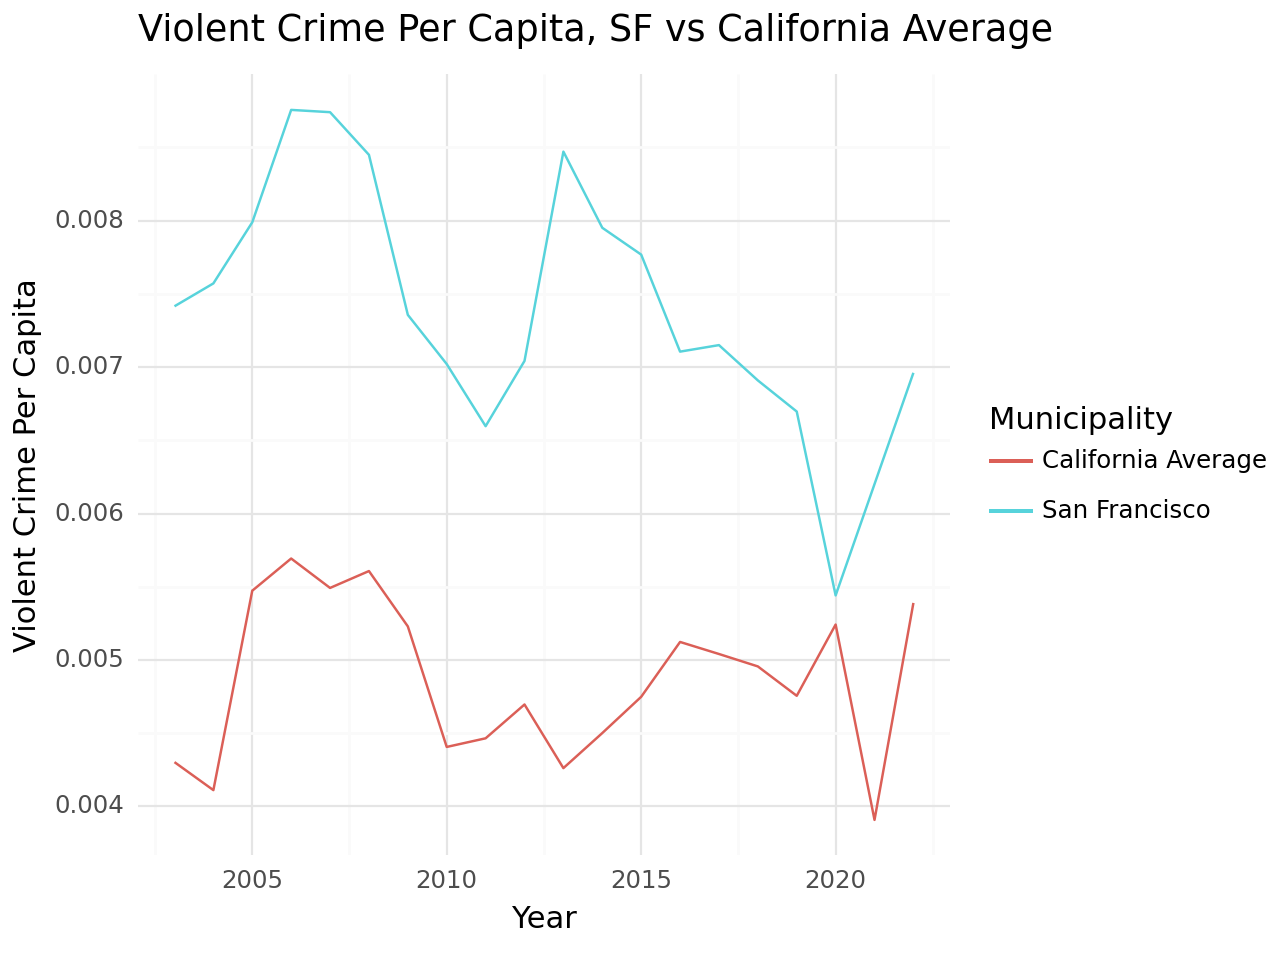

<Figure Size: (640 x 480)>

In [191]:
violent_graph = (
    p9.ggplot(violent_df, p9.aes(x = "year", y = "violent_rate", color = "type")) + p9.geom_line() +
    p9.theme_minimal() + p9.labs(x = "Year",
                                 y = "Violent Crime Per Capita",
                                 color = "Municipality",
                                 title = "Violent Crime Per Capita, SF vs California Average") 
)
violent_graph

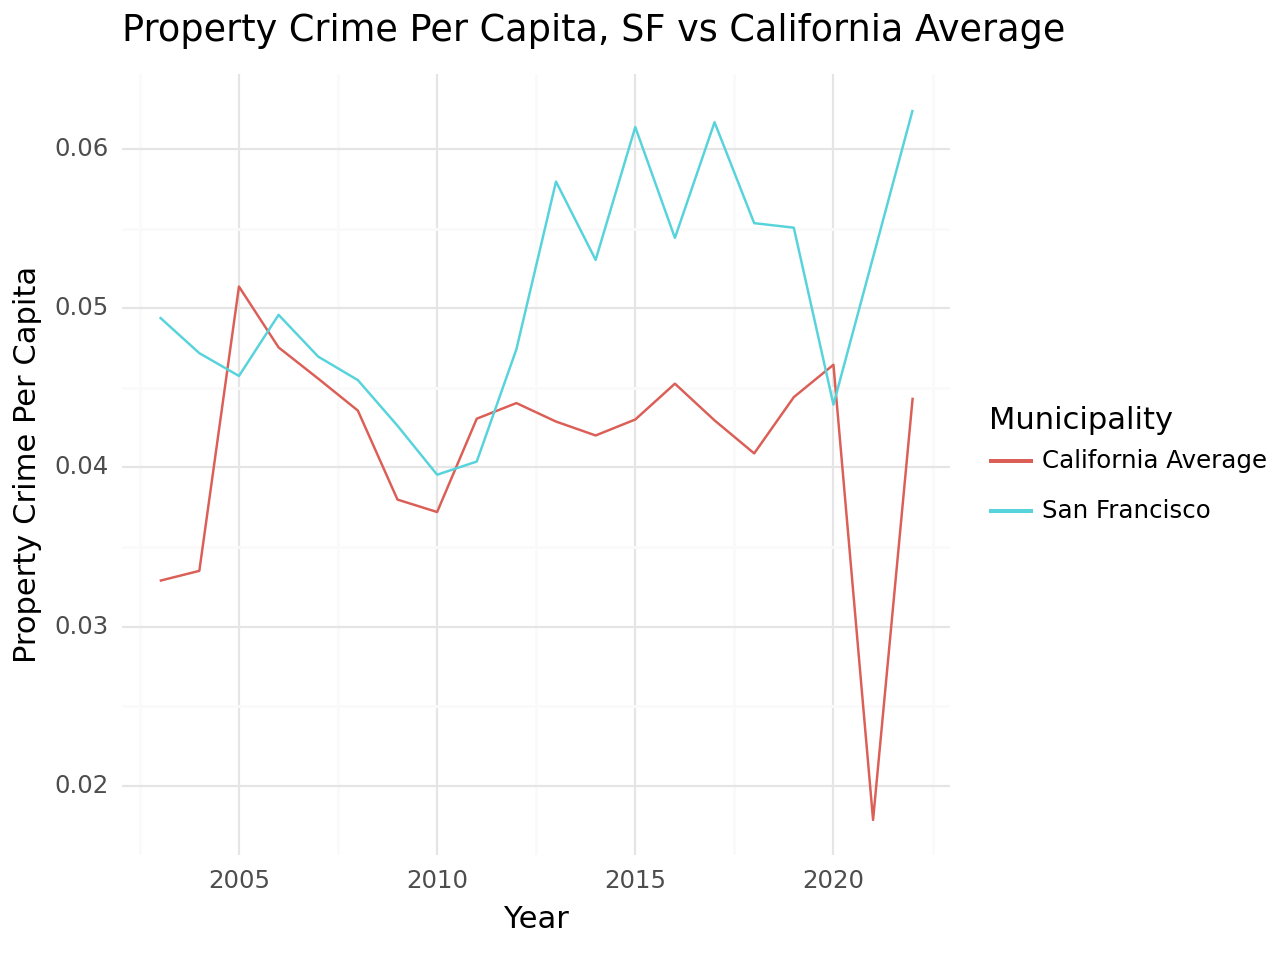

<Figure Size: (640 x 480)>

In [192]:
property_graph = (
    p9.ggplot(property_df, p9.aes(x = "year", y = "property_rate", color = "type")) + p9.geom_line() +
    p9.theme_minimal() + p9.labs(x = "Year",
                                 y = "Property Crime Per Capita",
                                 color = "Municipality",
                                 title = "Property Crime Per Capita, SF vs California Average") 
)
property_graph

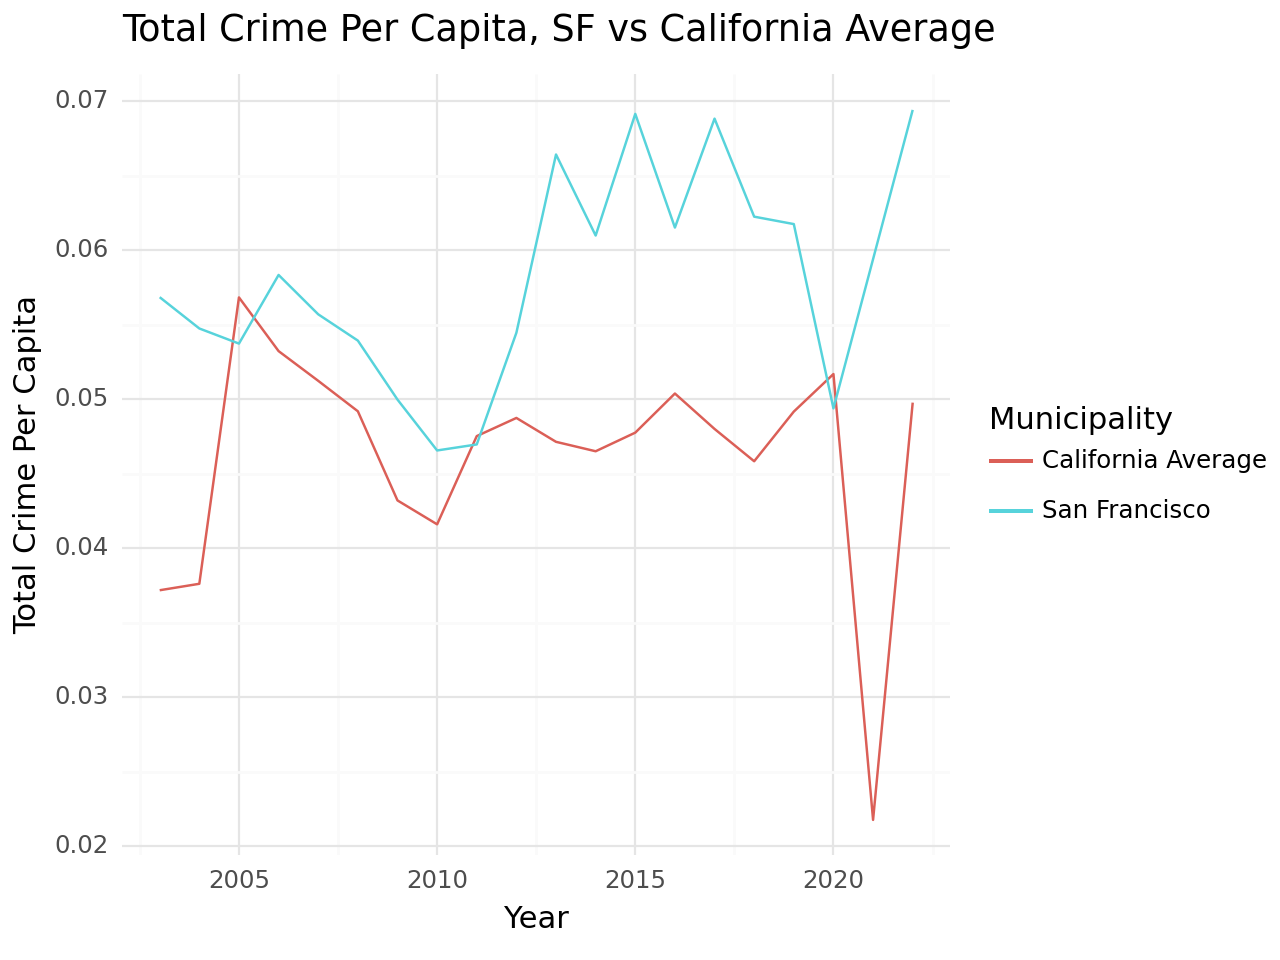

<Figure Size: (640 x 480)>

In [193]:
total_graph = (
    p9.ggplot(total_df, p9.aes(x = "year", y = "total_rate", color = "type")) + p9.geom_line() +
    p9.theme_minimal() + p9.labs(x = "Year",
                                 y = "Total Crime Per Capita",
                                 color = "Municipality",
                                 title = "Total Crime Per Capita, SF vs California Average") 
)
total_graph

In [194]:
p9.ggsave(violent_graph, "../visualizations/violent_graph.jpg", dpi = 300)
p9.ggsave(property_graph, "../visualizations/property_graph.jpg", dpi = 300)
p9.ggsave(total_graph, "../visualizations/total_graph.jpg", dpi = 300)

c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/violent_graph.jpg
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/property_graph.jpg
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/total_graph.jpg


In [195]:
cali_df.to_csv("../clean_data/cali_crime_w_rates.csv")

In [196]:
state_violent = list(violent_df["violent_rate"][violent_df["type"] == "California Average"])
sf_violent = list(violent_df["violent_rate"][violent_df["type"] == "San Francisco"])
stat, p_value = mannwhitneyu(state_violent, sf_violent)
alpha = 0.01
# conclusion 
if p_value < alpha: 
    print('Reject Null Hypothesis (Significant difference between two samples)') 
else: 
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Reject Null Hypothesis (Significant difference between two samples)


In [197]:
state_property = list(property_df["property_rate"][property_df["type"] == "California Average"])
sf_property = list(property_df["property_rate"][property_df["type"] == "San Francisco"])
stat, p_value = mannwhitneyu(state_property, sf_property)
alpha = 0.01
# conclusion 
if p_value < alpha: 
    print('Reject Null Hypothesis (Significant difference between two samples)') 
else: 
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Reject Null Hypothesis (Significant difference between two samples)


In [198]:
state_total = list(total_df["total_rate"][property_df["type"] == "California Average"])
sf_total = list(total_df["total_rate"][property_df["type"] == "San Francisco"])
stat, p_value = mannwhitneyu(state_total, sf_total)
alpha = 0.01
# conclusion 
if p_value < alpha: 
    print('Reject Null Hypothesis (Significant difference between two samples)') 
else: 
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Reject Null Hypothesis (Significant difference between two samples)


In [199]:
sf_df.to_csv("../clean_data/sf_crime.csv")

### e) Unemployment Regression Analysis

In [200]:
sf_crime = pd.read_csv("../clean_data/sf_crime.csv")
sf_unemployment = pd.read_csv("../clean_data/sf_unemployment.csv")
sf_crime = sf_crime.drop(["Unnamed: 0"], axis= 1)
sf_unemployment = sf_unemployment.drop(["Unnamed: 0"], axis= 1)


In [201]:
sf_crime = sf_crime.merge(sf_unemployment, how = "left", on="year")

In [202]:
sf_crime["unemployment_rate"] = sf_crime["unemployment average"]/sf_crime["population"]
sf_crime

,city,population,violent crime,murder and nonnegligent manslaughter,rape,robbery,aggravated assault,property crime,burglary,larceny-theft,motor vehicle theft,arson,state,year,violent_rate,property_rate,total_rate,unemployment average,unemployment_rate
0,San Francisco,764693.0,5323.0,55.0,308.0,2371.0,2589.0,47759.0,5947.0,35530.0,6282.0,344.0,California,2022,0.006961,0.062455,0.069416,14599.833333,0.019092
1,San Francisco,881514.0,4796.0,48.0,198.0,2388.0,2162.0,38737.0,7452.0,25319.0,5966.0,377.0,California,2020,0.005441,0.043944,0.049384,44465.583333,0.050442
2,San Francisco,886007.0,5933.0,40.0,324.0,3055.0,2514.0,48780.0,4644.0,39887.0,4249.0,275.0,California,2019,0.006696,0.055056,0.061752,12865.083333,0.014520
3,San Francisco,889282.0,6144.0,46.0,354.0,3165.0,2579.0,49214.0,5322.0,39675.0,4217.0,288.0,California,2018,0.006909,0.055341,0.062250,13639.416667,0.015338
4,San Francisco,881255.0,6301.0,56.0,367.0,3220.0,2658.0,54356.0,4935.0,44587.0,4834.0,303.0,California,2017,0.007150,0.061680,0.068830,16606.000000,0.018844
5,San Francisco,871155.0,6190.0,57.0,342.0,3175.0,2616.0,47402.0,4978.0,36991.0,5433.0,255.0,California,2016,0.007106,0.054413,0.061518,18344.416667,0.021058
6,San Francisco,863782.0,6710.0,53.0,344.0,3610.0,2703.0,53019.0,5186.0,40918.0,6915.0,272.0,California,2015,0.007768,0.061380,0.069148,19844.500000,0.022974
7,San Francisco,850294.0,6761.0,45.0,355.0,3224.0,3137.0,45093.0,5237.0,33730.0,6126.0,241.0,California,2014,0.007951,0.053032,0.060984,23335.666667,0.027444
8,San Francisco,833863.0,7064.0,48.0,161.0,4202.0,2653.0,48324.0,5931.0,36527.0,5866.0,227.0,California,2013,0.008471,0.057952,0.066423,28430.250000,0.034095
9,San Francisco,820363.0,5777.0,69.0,108.0,3484.0,2116.0,38898.0,5317.0,28242.0,5339.0,207.0,California,2012,0.007042,0.047416,0.054458,34978.333333,0.042638


c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/unemployment_graph_violent.jpg


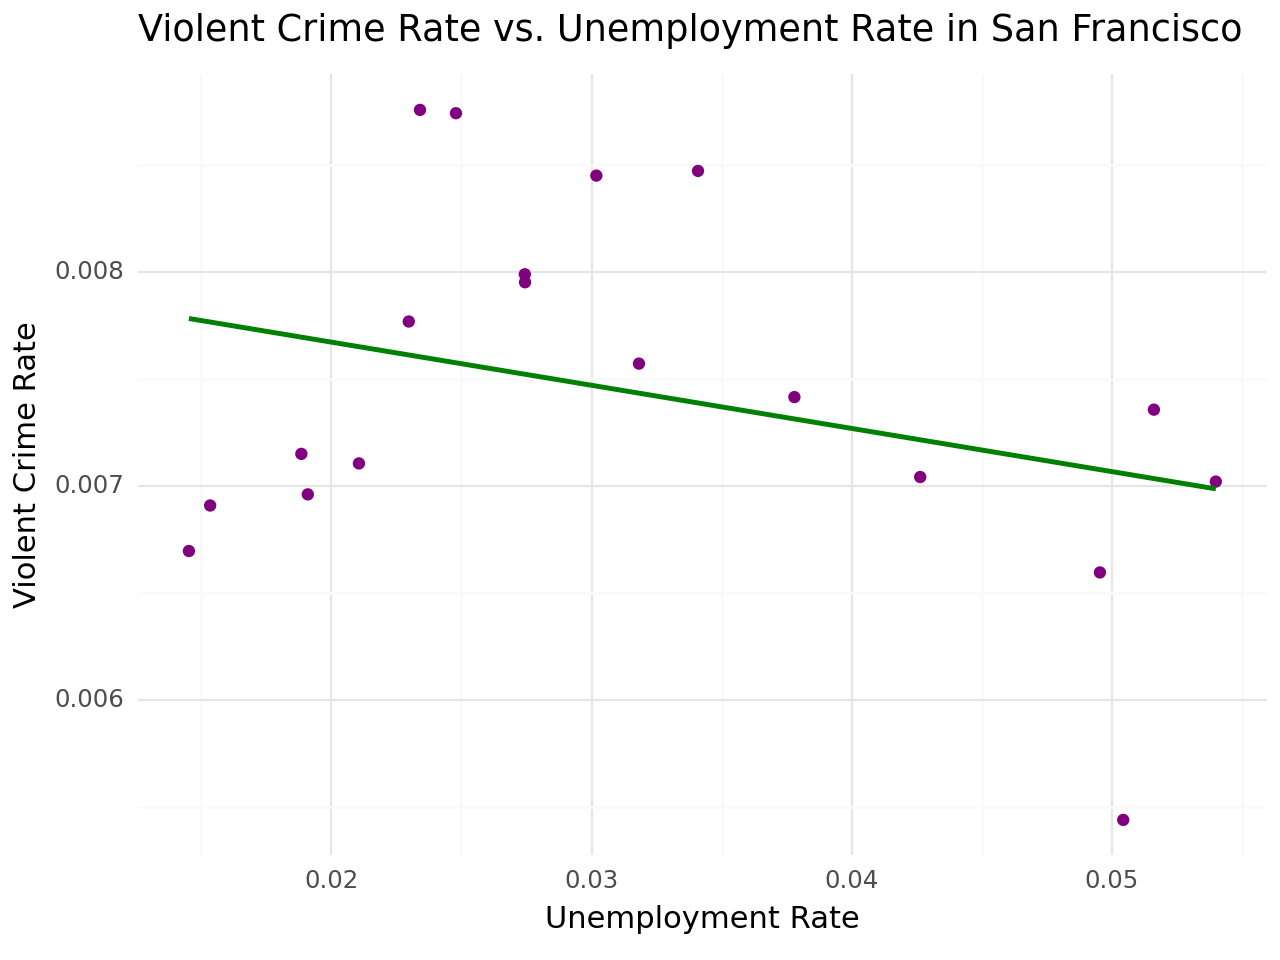

<Figure Size: (640 x 480)>

In [203]:
unemployment_graph_violent = (
    p9.ggplot(sf_crime, p9.aes(x = "unemployment_rate", y = "violent_rate")) + p9.geom_point(color = "purple")
    + p9.geom_smooth(method = "lm", se = False, color = "green") + p9.theme_minimal() +
    p9.labs(x = "Unemployment Rate",
            y = "Violent Crime Rate",
            title = "Violent Crime Rate vs. Unemployment Rate in San Francisco")
)
p9.ggsave(unemployment_graph_violent, "../visualizations/unemployment_graph_violent.jpg", dpi = 300)
unemployment_graph_violent

c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/unemployment_graph_property.jpg


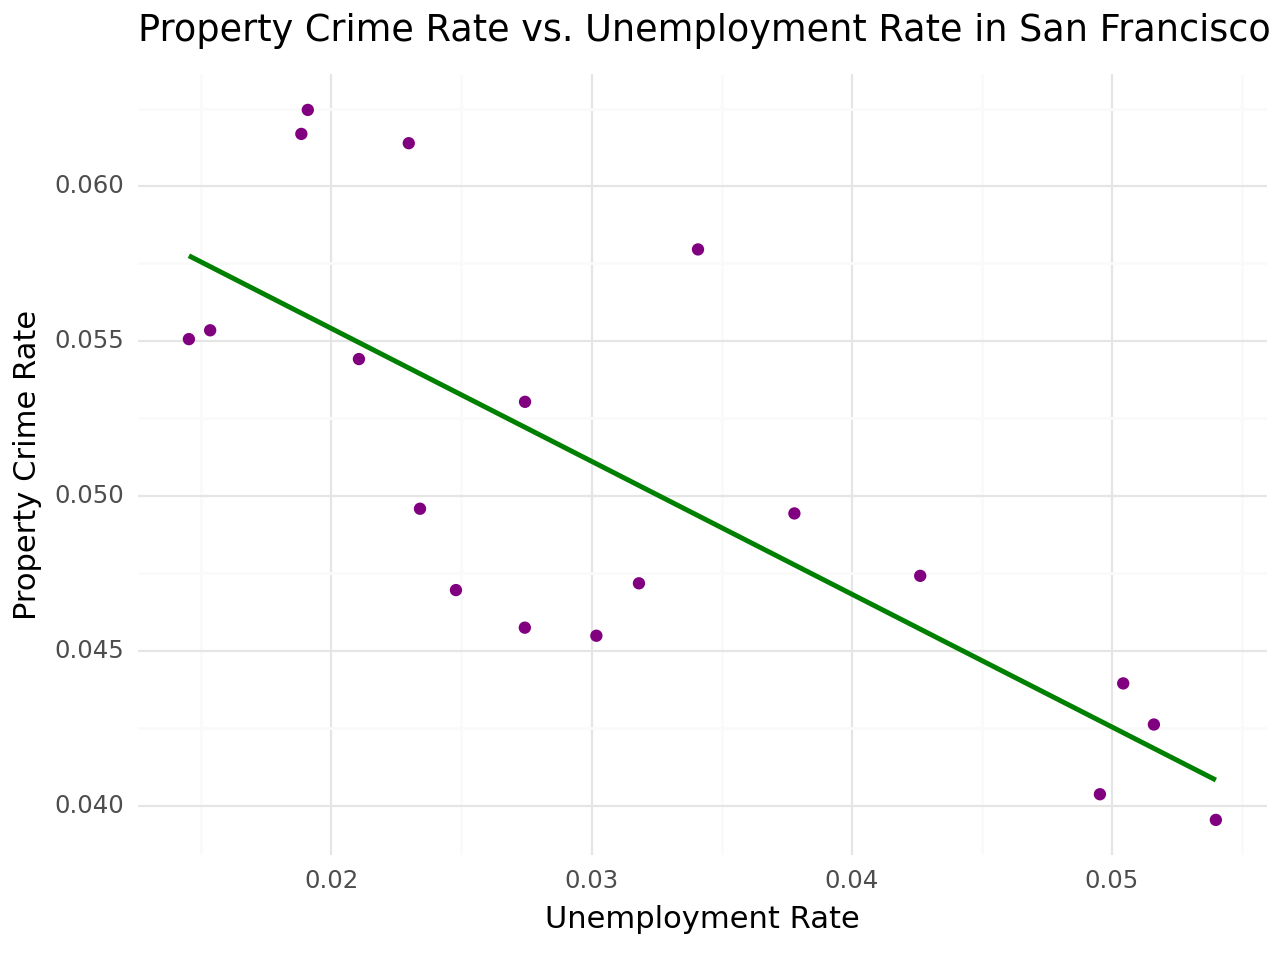

<Figure Size: (640 x 480)>

In [204]:
unemployment_graph_property = (
    p9.ggplot(sf_crime, p9.aes(x = "unemployment_rate", y = "property_rate")) + p9.geom_point(color = "purple")
    + p9.geom_smooth(method = "lm", se = False, color = "green") + p9.theme_minimal() +
    p9.labs(x = "Unemployment Rate",
            y = "Property Crime Rate",
            title = "Property Crime Rate vs. Unemployment Rate in San Francisco")
)
p9.ggsave(unemployment_graph_property, "../visualizations/unemployment_graph_property.jpg", dpi = 300)
unemployment_graph_property

c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/unemployment_graph_total.jpg


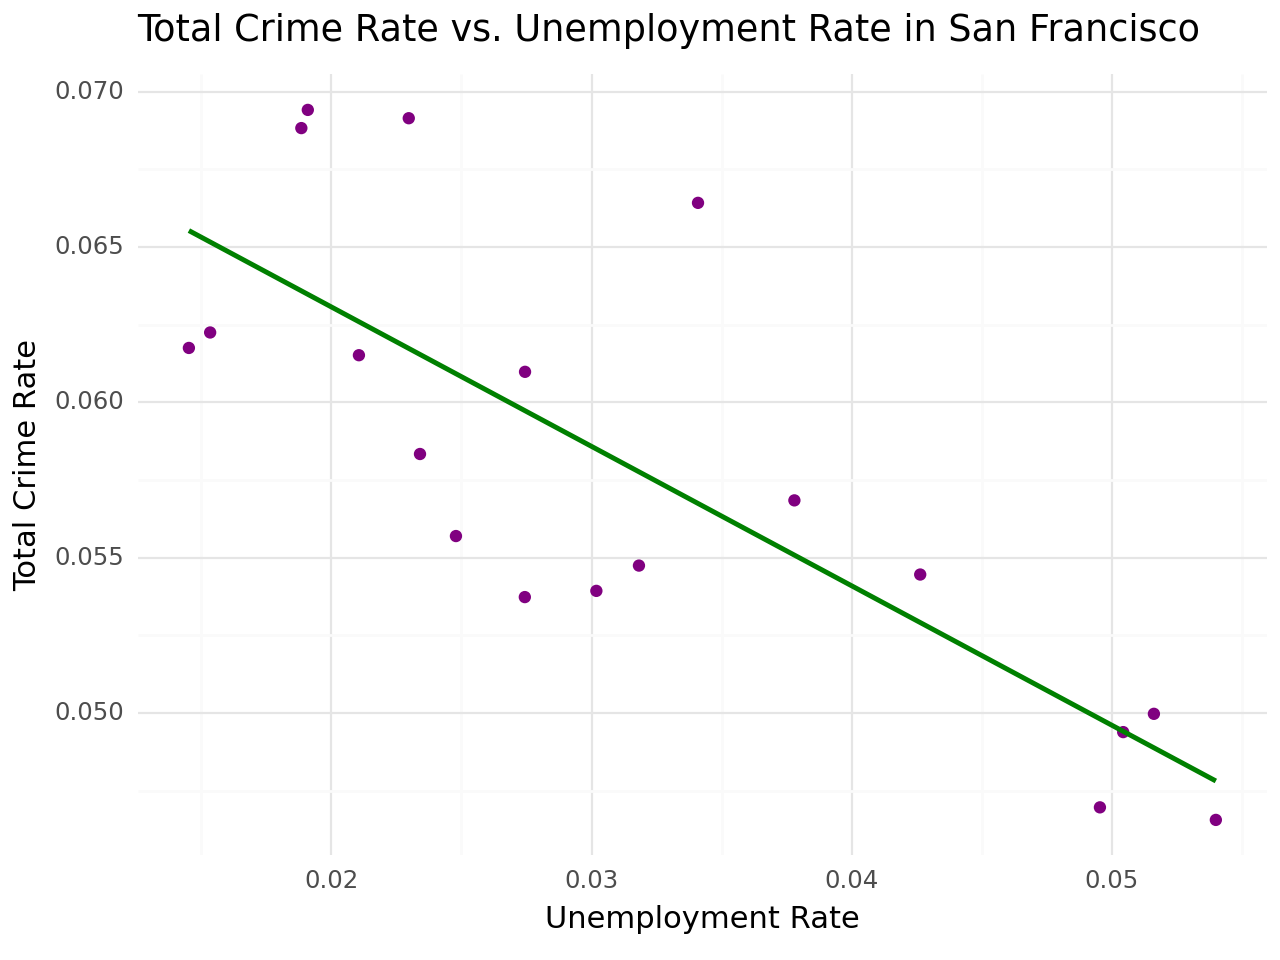

<Figure Size: (640 x 480)>

In [205]:
unemployment_graph_total = (
    p9.ggplot(sf_crime, p9.aes(x = "unemployment_rate", y = "total_rate")) + p9.geom_point(color = "purple")
    + p9.geom_smooth(method = "lm", se = False, color = "green") + p9.theme_minimal() +
    p9.labs(x = "Unemployment Rate",
            y = "Total Crime Rate",
            title = "Total Crime Rate vs. Unemployment Rate in San Francisco")
)
p9.ggsave(unemployment_graph_total, "../visualizations/unemployment_graph_total.jpg", dpi = 300)
unemployment_graph_total

In [206]:
y_rate = sf_crime["unemployment_rate"].tolist()
x_violent = sm.add_constant(sf_crime["violent_rate"].tolist())
x_property = sm.add_constant(sf_crime["property_rate"].tolist())
x_total = sm.add_constant(sf_crime["total_rate"].tolist())

In [207]:
violent_regression_unemployment = sm.OLS(y_rate, x_violent).fit()
print(violent_regression_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.805
Date:                Tue, 19 Mar 2024   Prob (F-statistic):              0.197
Time:                        15:20:55   Log-Likelihood:                 57.295
No. Observations:                  19   AIC:                            -110.6
Df Residuals:                      17   BIC:                            -108.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0669      0.027      2.520      0.0

c:\Users\herob\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


In [208]:
property_regression_unemployment = sm.OLS(y_rate, x_property).fit()
print(property_regression_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     24.60
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           0.000119
Time:                        15:20:55   Log-Likelihood:                 64.837
No. Observations:                  19   AIC:                            -125.7
Df Residuals:                      17   BIC:                            -123.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1011      0.014      7.129      0.0

c:\Users\herob\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


In [209]:
total_regression_unemployment = sm.OLS(y_rate, x_total).fit()
print(total_regression_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     28.38
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           5.56e-05
Time:                        15:20:55   Log-Likelihood:                 65.663
No. Observations:                  19   AIC:                            -127.3
Df Residuals:                      17   BIC:                            -125.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1122      0.015      7.346      0.0

c:\Users\herob\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


### f) Housing Regression Analysis

In [210]:
sf_crime = pd.read_csv("../clean_data/sf_crime.csv")
sf_crime = sf_crime.drop(["Unnamed: 0"], axis= 1)

housing = pd.read_csv("../clean_data/housing.csv")
housing = housing.drop(index=18)
housing.reset_index(inplace=True)

In [211]:
y = housing['mean_sale'].tolist()
x_violent = sm.add_constant(sf_crime["violent_rate"].tolist())
x_property = sm.add_constant(sf_crime["property_rate"].tolist())
x_total = sm.add_constant(sf_crime["total_rate"].tolist())

#### Mean Housing Prices Vs Crime Rates

In [212]:
violent_regression_housing = sm.OLS(y, x_violent).fit()
print(violent_regression_housing.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     5.847
Date:                Tue, 19 Mar 2024   Prob (F-statistic):             0.0271
Time:                        15:20:55   Log-Likelihood:                -265.94
No. Observations:                  19   AIC:                             535.9
Df Residuals:                      17   BIC:                             537.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -3.91e+05   6.49e+05     -0.602      0.5

c:\Users\herob\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


In [213]:
property_regression_housing = sm.OLS(y, x_property).fit()
print(property_regression_housing.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     7.823
Date:                Tue, 19 Mar 2024   Prob (F-statistic):             0.0124
Time:                        15:20:55   Log-Likelihood:                -265.15
No. Observations:                  19   AIC:                             534.3
Df Residuals:                      17   BIC:                             536.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.54e+06   4.95e+05      5.134      0.0

c:\Users\herob\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


In [214]:
property_regression_total = sm.OLS(y, x_total).fit()
print(property_regression_total.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     5.471
Date:                Tue, 19 Mar 2024   Prob (F-statistic):             0.0318
Time:                        15:20:55   Log-Likelihood:                -266.10
No. Observations:                  19   AIC:                             536.2
Df Residuals:                      17   BIC:                             538.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.527e+06   5.85e+05      4.321      0.0

c:\Users\herob\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


In [215]:
x = housing['mean_sale']

c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/housing_violent_graph.jpg


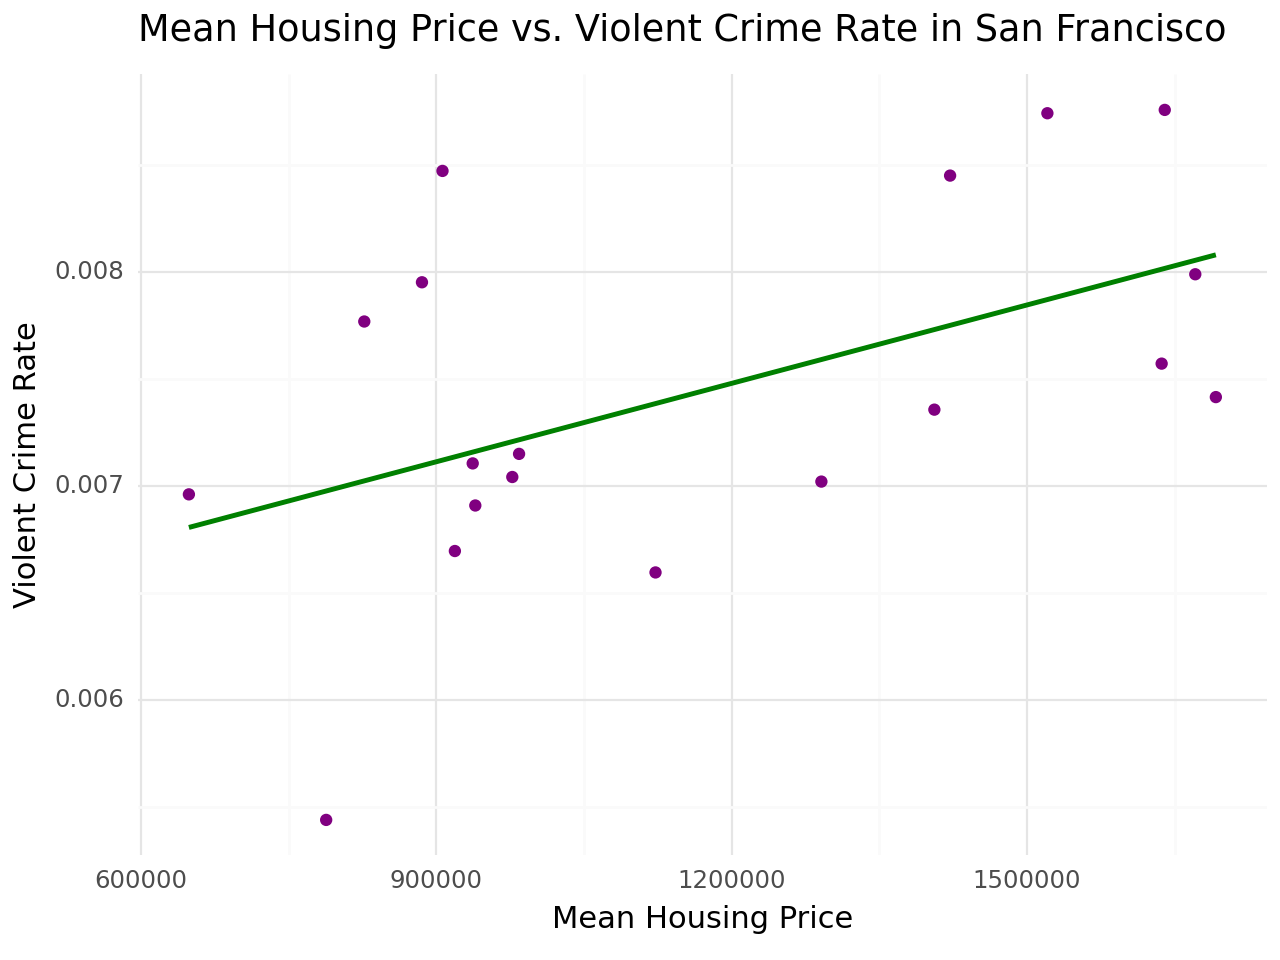

<Figure Size: (640 x 480)>

In [216]:
housing_violent_graph = (
    p9.ggplot(sf_crime, p9.aes(x = x, y = "violent_rate")) + p9.geom_point(color = "purple")
    + p9.geom_smooth(method = "lm", se = False, color = "green") + p9.theme_minimal() +
    p9.labs(x = "Mean Housing Price",
            y = "Violent Crime Rate",
            title = "Mean Housing Price vs. Violent Crime Rate in San Francisco")
)
p9.ggsave(housing_violent_graph, "../visualizations/housing_violent_graph.jpg", dpi = 300)
housing_violent_graph

c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/housing_property_graph.jpg


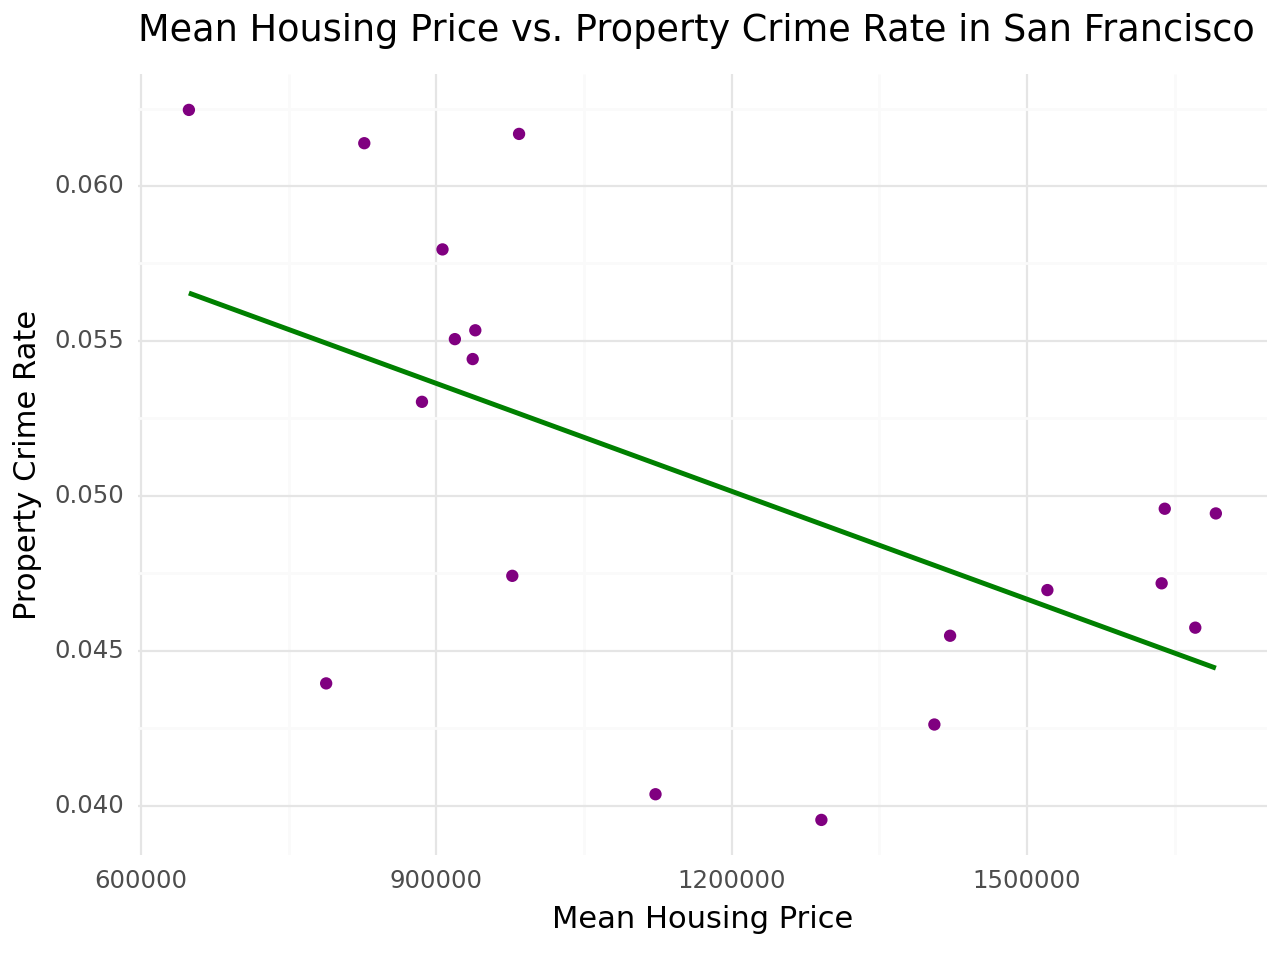

<Figure Size: (640 x 480)>

In [217]:
housing_property_graph = (
    p9.ggplot(sf_crime, p9.aes(x = x, y = "property_rate")) + p9.geom_point(color = "purple")
    + p9.geom_smooth(method = "lm", se = False, color = "green") + p9.theme_minimal() +
    p9.labs(x = "Mean Housing Price",
            y = "Property Crime Rate",
            title = "Mean Housing Price vs. Property Crime Rate in San Francisco")
)

p9.ggsave(housing_property_graph, "../visualizations/housing_property_graph.jpg", dpi = 300)
housing_property_graph

c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\herob\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../visualizations/housing_total_graph.jpg


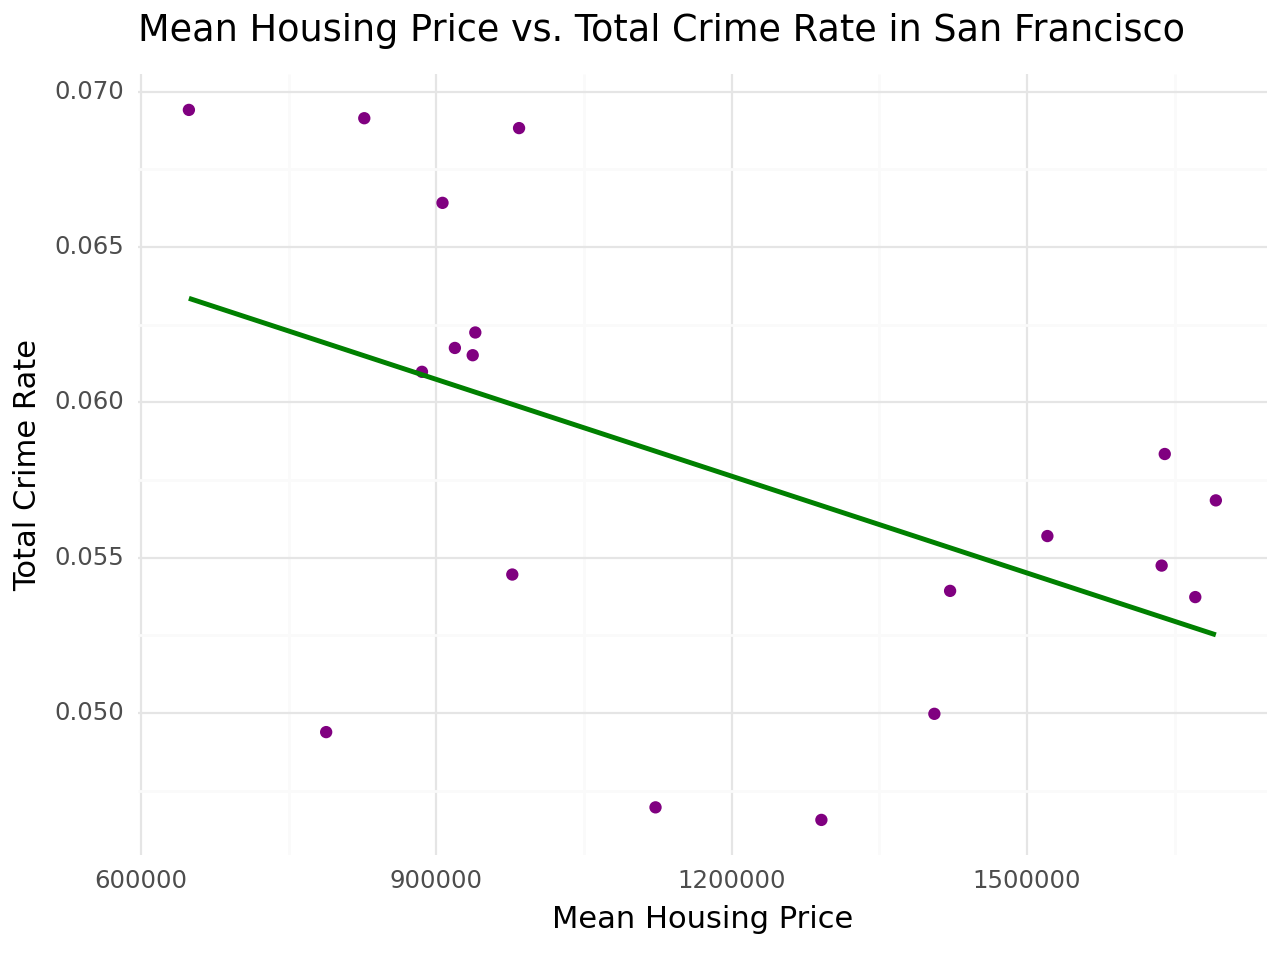

<Figure Size: (640 x 480)>

In [218]:
housing_total_graph = (
    p9.ggplot(sf_crime, p9.aes(x = x, y = "total_rate")) + p9.geom_point(color = "purple")
    + p9.geom_smooth(method = "lm", se = False, color = "green") + p9.theme_minimal() +
    p9.labs(x = "Mean Housing Price",
            y = "Total Crime Rate",
            title = "Mean Housing Price vs. Total Crime Rate in San Francisco")
)
p9.ggsave(housing_total_graph, "../visualizations/housing_total_graph.jpg", dpi = 300)
housing_total_graph